In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model

In [ ]:
(x_train, y_train), (x_test, y_test)=tf.keras.datasets.mnist.load_data()
x_train = tf.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])/255
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)
x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)
x_val = x_train[-2000:,:,:]
y_val = y_train[-2000:]
x_train = x_train[:-2000,:,:]
y_train = y_train[:-2000]

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
def inception(x,
              filters_1x1,
              filters_3x3_reduce,
              filters_3x3,
              filters_5x5_reduce,
              filters_5x5,
              filters_pool):
  path1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

  path2 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
  path2 = layers.Conv2D(filters_3x3, (1, 1), padding='same', activation='relu')(path2)

  path3 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
  path3 = layers.Conv2D(filters_5x5, (1, 1), padding='same', activation='relu')(path3)

  path4 = layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  path4 = layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(path4)

  return tf.concat([path1, path2, path3, path4], axis=3)

In [ ]:
inp = layers.Input(shape=(32, 32, 3))
input_tensor = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=x_train.shape[1:])(inp)

x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(input_tensor)
x = layers.MaxPooling2D(3, strides=2)(x)

x = layers.Conv2D(64, 1, strides=1, padding='same', activation='relu')(x)
x = layers.Conv2D(192, 3, strides=1, padding='same', activation='relu')(x)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=64,
              filters_3x3_reduce=96,
              filters_3x3=128,
              filters_5x5_reduce=16,
              filters_5x5=32,
              filters_pool=32)

x = inception(x,
              filters_1x1=128,
              filters_3x3_reduce=128,
              filters_3x3=192,
              filters_5x5_reduce=32,
              filters_5x5=96,
              filters_pool=64)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=192,
              filters_3x3_reduce=96,
              filters_3x3=208,
              filters_5x5_reduce=16,
              filters_5x5=48,
              filters_pool=64)

aux1 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux1 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux1)
aux1 = layers.Flatten()(aux1)
aux1 = layers.Dense(1024, activation='relu')(aux1)
aux1 = layers.Dropout(0.7)(aux1)
aux1 = layers.Dense(10, activation='softmax')(aux1)

x = inception(x,
              filters_1x1=160,
              filters_3x3_reduce=112,
              filters_3x3=224,
              filters_5x5_reduce=24,
              filters_5x5=64,
              filters_pool=64)

x = inception(x,
              filters_1x1=128,
              filters_3x3_reduce=128,
              filters_3x3=256,
              filters_5x5_reduce=24,
              filters_5x5=64,
              filters_pool=64)

x = inception(x,
              filters_1x1=112,
              filters_3x3_reduce=144,
              filters_3x3=288,
              filters_5x5_reduce=32,
              filters_5x5=64,
              filters_pool=64)

aux2 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux2 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux2)
aux2 = layers.Flatten()(aux2)
aux2 = layers.Dense(1024, activation='relu')(aux2)
aux2 = layers.Dropout(0.7)(aux2)
aux2 = layers.Dense(10, activation='softmax')(aux2)

x = inception(x,
              filters_1x1=256,
              filters_3x3_reduce=160,
              filters_3x3=320,
              filters_5x5_reduce=32,
              filters_5x5=128,
              filters_pool=128)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=256,
              filters_3x3_reduce=160,
              filters_3x3=320,
              filters_5x5_reduce=32,
              filters_5x5=128,
              filters_pool=128)

x = inception(x,
              filters_1x1=384,
              filters_3x3_reduce=192,
              filters_3x3=384,
              filters_5x5_reduce=48,
              filters_5x5=128,
              filters_pool=128)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.4)(x)
out = layers.Dense(10, activation='softmax')(x)

In [ ]:
model = Model(inputs = inp, outputs = [out, aux1, aux2])

In [ ]:
model.compile(optimizer='adam', loss=[losses.sparse_categorical_crossentropy, losses.sparse_categorical_crossentropy, losses.sparse_categorical_crossentropy], loss_weights=[1, 0.3, 0.3], metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, [y_train, y_train, y_train], validation_data=(x_val, [y_val, y_val, y_val]), batch_size=64, epochs=5)

Epoch 1/5
907/907 [==============================] - 182s 159ms/step - loss: 1.2023 - dense_4_loss: 0.8676 - dense_1_loss: 0.5369 - dense_3_loss: 0.5789 - dense_4_accuracy: 0.6924 - dense_1_accuracy: 0.8188 - dense_3_accuracy: 0.8005 - val_loss: 0.2126 - val_dense_4_loss: 0.1565 - val_dense_1_loss: 0.0907 - val_dense_3_loss: 0.0961 - val_dense_4_accuracy: 0.9560 - val_dense_1_accuracy: 0.9785 - val_dense_3_accuracy: 0.9745
Epoch 2/5
907/907 [==============================] - 142s 157ms/step - loss: 0.2282 - dense_4_loss: 0.1545 - dense_1_loss: 0.1170 - dense_3_loss: 0.1285 - dense_4_accuracy: 0.9536 - dense_1_accuracy: 0.9653 - dense_3_accuracy: 0.9611 - val_loss: 0.0877 - val_dense_4_loss: 0.0533 - val_dense_1_loss: 0.0599 - val_dense_3_loss: 0.0546 - val_dense_4_accuracy: 0.9855 - val_dense_1_accuracy: 0.9830 - val_dense_3_accuracy: 0.9845
Epoch 3/5
907/907 [==============================] - 141s 156ms/step - loss: 0.1571 - dense_4_loss: 0.1048 - dense_1_loss: 0.0839 - dense_3_loss: 

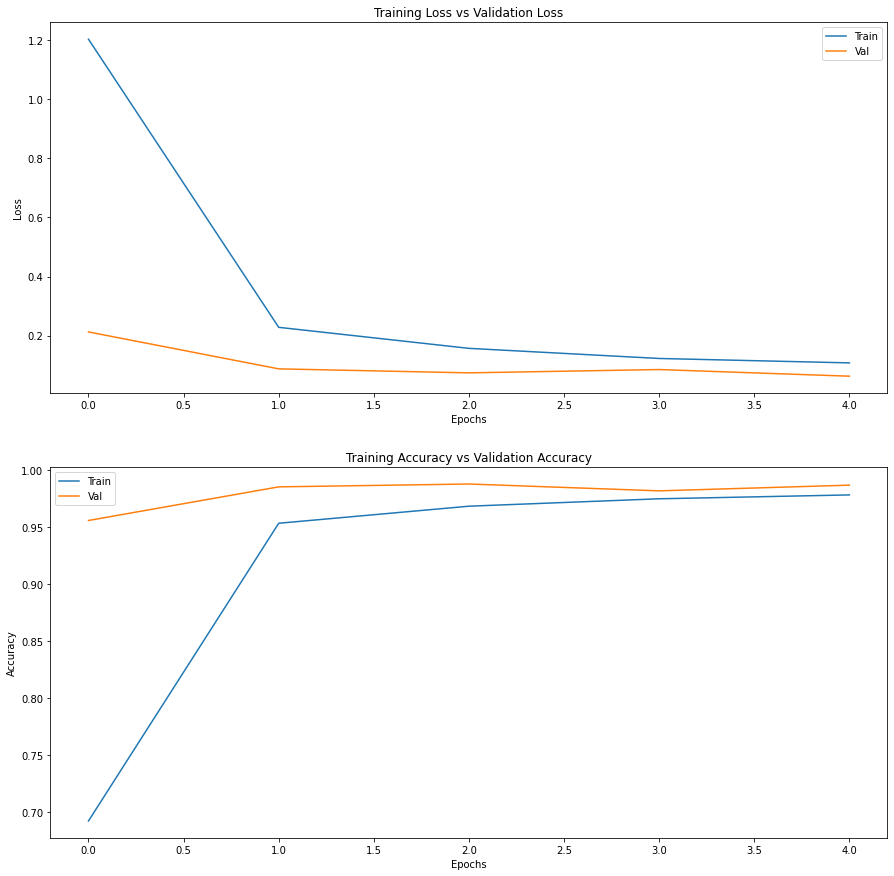

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['dense_4_accuracy'])
axs[1].plot(history.history['val_dense_4_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 10s 27ms/step - loss: 0.0723 - dense_4_loss: 0.0502 - dense_1_loss: 0.0377 - dense_3_loss: 0.0359 - dense_4_accuracy: 0.9833 - dense_1_accuracy: 0.9883 - dense_3_accuracy: 0.9880


[0.07228653132915497,
 0.0502057746052742,
 0.0377136655151844,
 0.03588878735899925,
 0.983299970626831,
 0.9883000254631042,
 0.9879999756813049]

Visualizing 1*1 conv


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)


In [ ]:
# Neural network with a convolutional layer
inputs1 = Input(shape=(28, 28, 1))
x1 = Conv2D(32, (3, 3), activation='relu')(inputs1)
x1 = MaxPooling2D((2, 2))(x1)
x1 = Flatten()(x1)
outputs1 = Dense(10, activation='softmax')(x1)

model1 = Model(inputs1, outputs1)

# Neural network with a 1x1 convolutional layer
inputs2 = Input(shape=(28, 28, 1))
x2 = Conv2D(32, (1, 1), activation='relu')(inputs2)
x2 = Conv2D(32, (3, 3), activation='relu')(x2)
x2 = MaxPooling2D((2, 2))(x2)
x2 = Flatten()(x2)
outputs2 = Dense(10, activation='softmax')(x2)

model2 = Model(inputs2, outputs2)


In [ ]:
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model1.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))


Epoch 1/10
469/469 [==============================] - 3s 4ms/step - loss: 1.0870 - accuracy: 0.9242 - val_loss: 0.2085 - val_accuracy: 0.9611
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1293 - accuracy: 0.9724 - val_loss: 0.1238 - val_accuracy: 0.9708
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0650 - accuracy: 0.9825 - val_loss: 0.0996 - val_accuracy: 0.9746
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0447 - accuracy: 0.9864 - val_loss: 0.0958 - val_accuracy: 0.9787
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0351 - accuracy: 0.9890 - val_loss: 0.1145 - val_accuracy: 0.9748
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0288 - accuracy: 0.9906 - val_loss: 0.1259 - val_accuracy: 0.9733
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0304 - accuracy: 0.9906 - val_loss: 0.1296 - val_accuracy: 0.9733
Epoch 

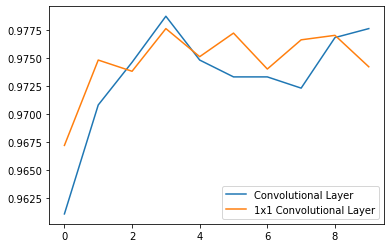

In [ ]:
plt.plot(model1.history.history['val_accuracy'], label='Convolutional Layer')
plt.plot(model2.history.history['val_accuracy'], label='1x1 Convolutional Layer')
plt.legend()
plt.show()


BATCH NORMALISATION


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization
from tensorflow.keras.models import Model

(x_train, y_train), (x_test, y_test) = mnist.load_data()


In [ ]:
x_train = x_train.reshape(-1, 28*28).astype('float32') / 255.
x_test = x_test.reshape(-1, 28*28).astype('float32') / 255.


In [ ]:
# Neural network without Batch Normalization
inputs1 = Input(shape=(784,))
x1 = Dense(128, activation='relu')(inputs1)
x1 = Dense(64, activation='relu')(x1)
outputs1 = Dense(10, activation='softmax')(x1)

model1 = Model(inputs1, outputs1)

# Neural network with Batch Normalization
inputs2 = Input(shape=(784,))
x2 = Dense(128, activation='relu')(inputs2)
x2 = BatchNormalization()(x2)
x2 = Dense(64, activation='relu')(x2)
x2 = BatchNormalization()(x2)
outputs2 = Dense(10, activation='softmax')(x2)

model2 = Model(inputs2, outputs2)


In [ ]:
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model1.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))


Epoch 1/10
469/469 [==============================] - 3s 4ms/step - loss: 1.2900 - accuracy: 0.6339 - val_loss: 0.6806 - val_accuracy: 0.7910
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.5872 - accuracy: 0.8205 - val_loss: 0.5072 - val_accuracy: 0.8485
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.4632 - accuracy: 0.8615 - val_loss: 0.4076 - val_accuracy: 0.8771
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3959 - accuracy: 0.8836 - val_loss: 0.3636 - val_accuracy: 0.8935
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3566 - accuracy: 0.8954 - val_loss: 0.3370 - val_accuracy: 0.9015
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3302 - accuracy: 0.9041 - val_loss: 0.3111 - val_accuracy: 0.9081
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3087 - accuracy: 0.9105 - val_loss: 0.2926 - val_accuracy: 0.9145
Epoch 

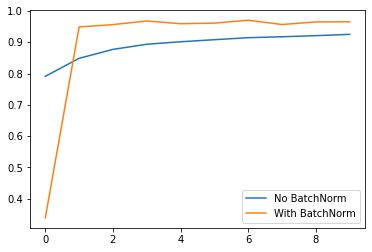

In [ ]:
plt.plot(model1.history.history['val_accuracy'], label='No BatchNorm')
plt.plot(model2.history.history['val_accuracy'], label='With BatchNorm')
plt.legend()
plt.show()
